In [2]:
import os
import sys
import torch
%load_ext autoreload
%autoreload 2
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts/')
sys.path.append('/Users/sarahurbut/aladynoulli2/claudefile/')


In [3]:
ckpt_used_for_phi=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_0_10000.pt')

# Extract phi from the checkpoint used for fixed phi work
if 'model_state_dict' in ckpt_used_for_phi and 'phi' in ckpt_used_for_phi['model_state_dict']:
    phi_fixed = ckpt_used_for_phi['model_state_dict']['phi']
elif 'phi' in ckpt_used_for_phi:
    phi_fixed = ckpt_used_for_phi['phi']
else:
    raise ValueError("No phi found in checkpoint")

# Convert to numpy if tensor
if torch.is_tensor(phi_fixed):
    phi_fixed = phi_fixed.detach().cpu().numpy()

print(f"Loaded phi from fixed phi checkpoint, shape: {phi_fixed.shape}")

Loaded phi from fixed phi checkpoint, shape: (21, 348, 52)


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50147/3728522181.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_used_for_phi=torch.load('/Users/sarahurb

In [4]:
import glob
import numpy as np
import matplotlib.pyplot as plt

def load_phis_from_batches(base_dir_pattern, max_batches=50):
    """
    Load phi from all batch files matching the pattern.
    
    Args:
        base_dir_pattern: Pattern like '/path/to/enrollment_model_W0.0001_batch_*_*.pt'
        max_batches: Maximum number of batches to load
    
    Returns:
        List of phi arrays
    """
    all_phis = []
    
    # Find all matching files
    files = sorted(glob.glob(base_dir_pattern))
    print(f"Found {len(files)} files matching pattern: {base_dir_pattern}")
    
    for file_path in files[:max_batches]:
        try:
            checkpoint = torch.load(file_path, weights_only=False)
            
            # Extract phi
            if 'model_state_dict' in checkpoint and 'phi' in checkpoint['model_state_dict']:
                phi = checkpoint['model_state_dict']['phi']
            elif 'phi' in checkpoint:
                phi = checkpoint['phi']
            else:
                print(f"Warning: No phi found in {file_path}")
                continue
            
            # Convert to numpy if tensor
            if torch.is_tensor(phi):
                phi = phi.detach().cpu().numpy()
            
            all_phis.append(phi)
            print(f"Loaded phi from {file_path}, shape: {phi.shape}")
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            continue
    
    return all_phis

def calculate_standard_errors(all_phis):
    """
    Calculate standard errors across batches for all phi parameters.
    
    Args:
        all_phis: List of phi arrays, each of shape (K, D, T)
    
    Returns:
        Array of standard errors for all K, D, T combinations
    """
    if len(all_phis) == 0:
        return None
    
    # Stack all phis: shape (n_batches, K, D, T)
    phi_stack = np.stack(all_phis, axis=0)
    n_batches = phi_stack.shape[0]
    
    # Calculate standard error for each (K, D, T) combination
    # SE = std / sqrt(n)
    std_phi = np.std(phi_stack, axis=0)  # (K, D, T)
    se_phi = std_phi / np.sqrt(n_batches)
    
    # Flatten to get all standard errors
    all_ses = se_phi.flatten()
    
    return all_ses, phi_stack

# Define the three configurations
configs = {
    'full_retrospective_with_pcs': '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_*_*.pt',
    'fixed_phi_with_pcs': '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_withpcs_fromclaudeoutput/model_enroll_fixedphi_sex_*_*.pt',
    'full_retrospective_no_pcs': '/Users/sarahurbut/Library/CloudStorage/Dropbox/ret_full_nopc_withsex/enrollment_model_W0.0001_batch_*_*.pt',
    'enrollment_joint_with_pcs': '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_prediction_jointphi_sex_pcs/enrollment_model_W0.0001_batch_*_*.pt'
}

# Load phis for each configuration
results = {}
for config_name, pattern in configs.items():
    print(f"\n{'='*80}")
    print(f"Loading {config_name}")
    print(f"{'='*80}")
    all_phis = load_phis_from_batches(pattern)
    
    if len(all_phis) > 0:
        all_ses, phi_stack = calculate_standard_errors(all_phis)
        results[config_name] = {
            'all_ses': all_ses,
            'phi_stack': phi_stack,
            'n_batches': len(all_phis)
        }
        print(f"\n{config_name}: Loaded {len(all_phis)} batches")
        print(f"Standard Error Summary:")
        print(f"  Mean SE: {all_ses.mean():.4f}")
        print(f"  Median SE: {np.median(all_ses):.4f}")
        print(f"  95th percentile SE: {np.percentile(all_ses, 95):.4f}")
    else:
        print(f"Warning: No batches loaded for {config_name}")

print(f"\n{'='*80}")
print("Summary: All configurations loaded")
print(f"{'='*80}")


Loading full_retrospective_with_pcs
Found 40 files matching pattern: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_*_*.pt
Loaded phi from /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_0_10000.pt, shape: (21, 348, 52)
Loaded phi from /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_100000_110000.pt, shape: (21, 348, 52)
Loaded phi from /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_10000_20000.pt, shape: (21, 348, 52)
Loaded phi from /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_110000_120000.pt, shape: (21, 348, 52)
Loaded phi from /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_120000_130000.pt, shape: (21, 348, 52)
Loaded p

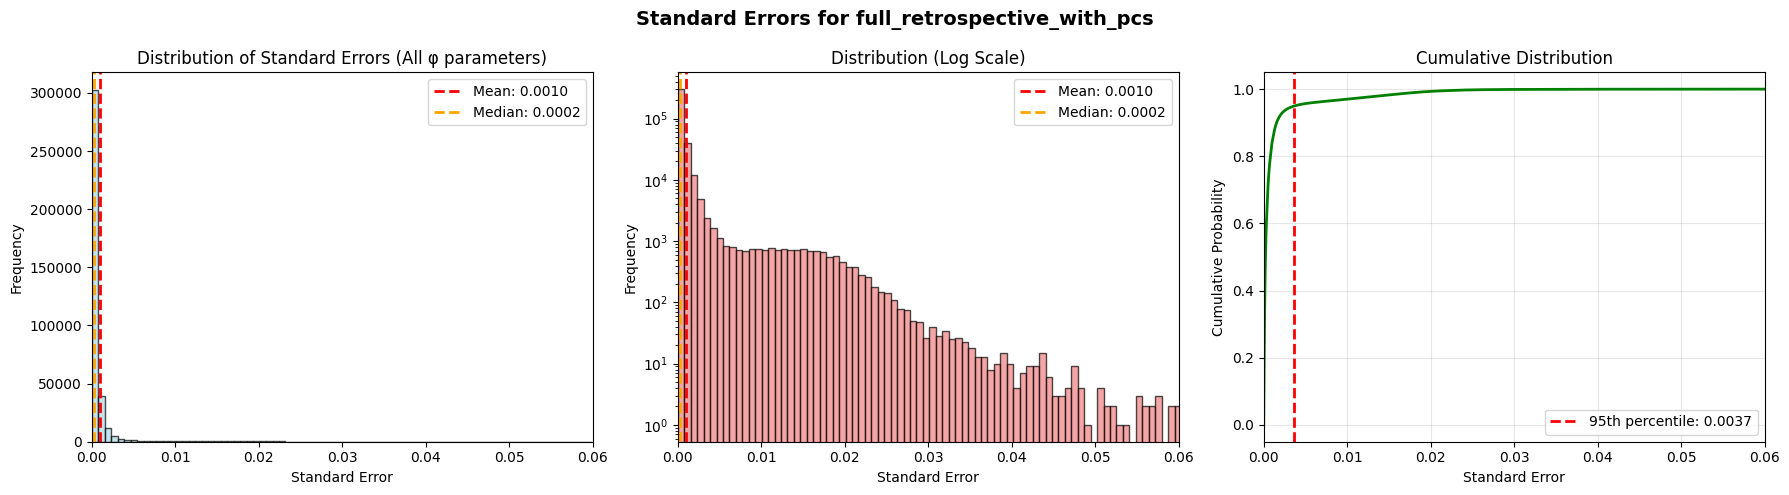

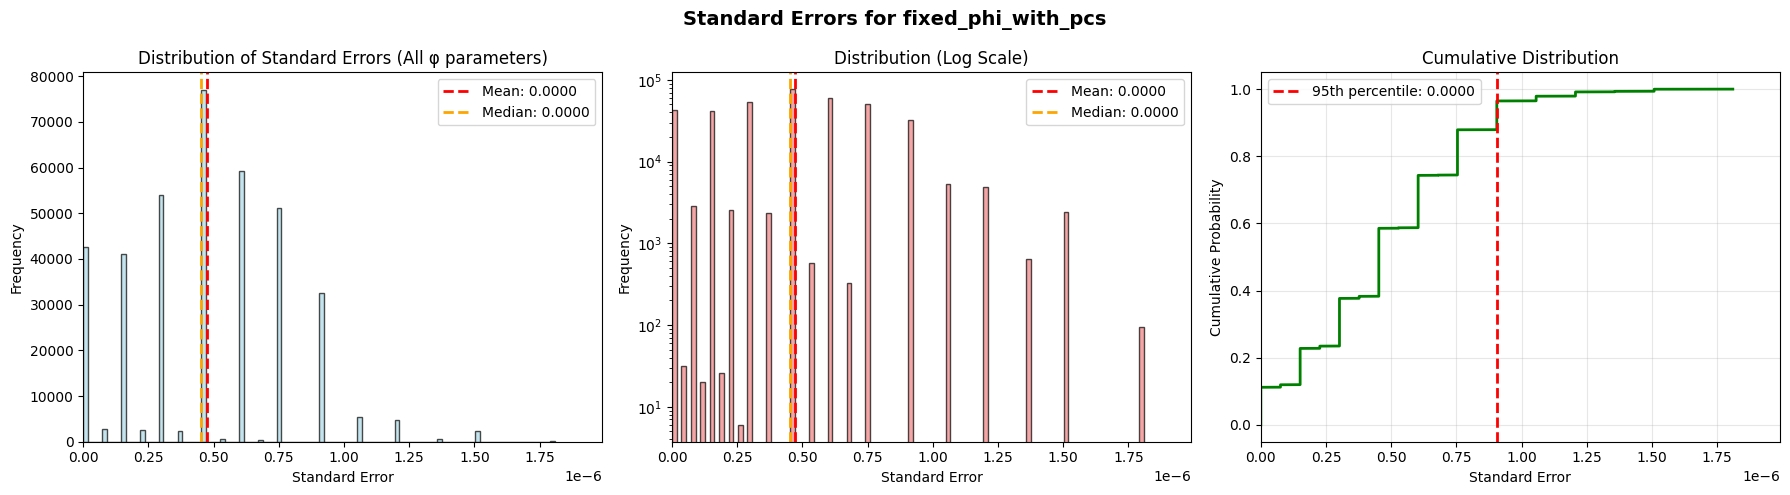

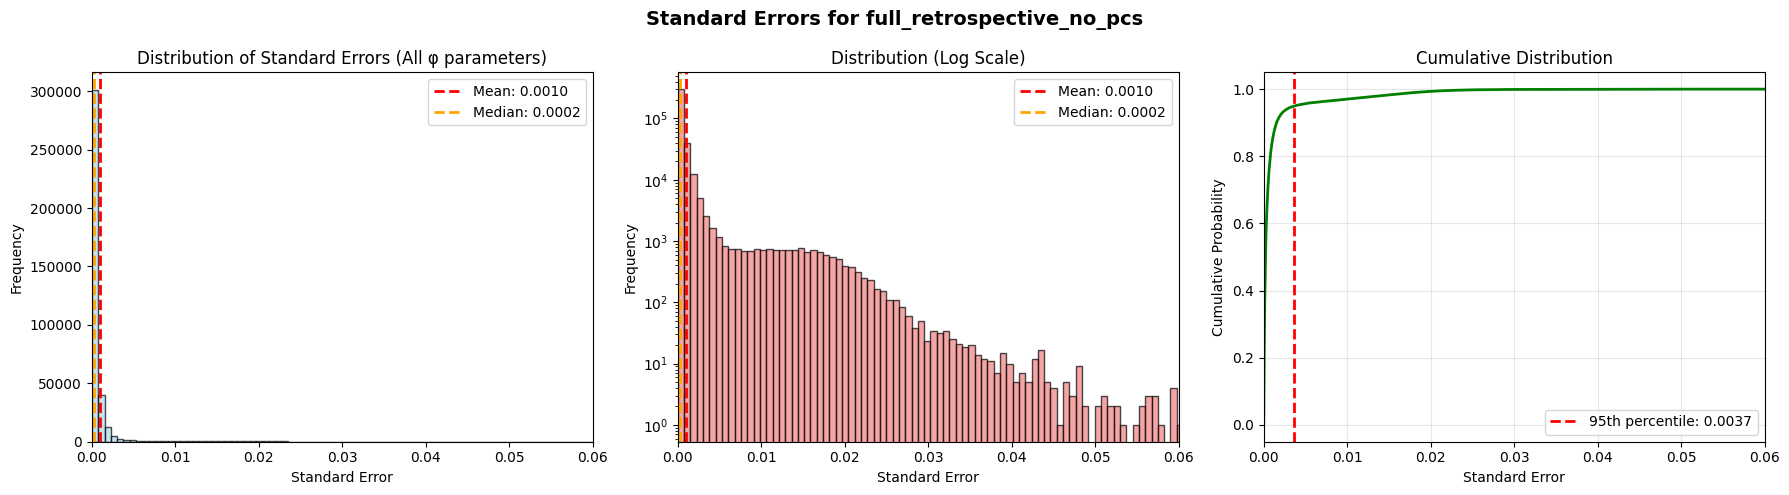

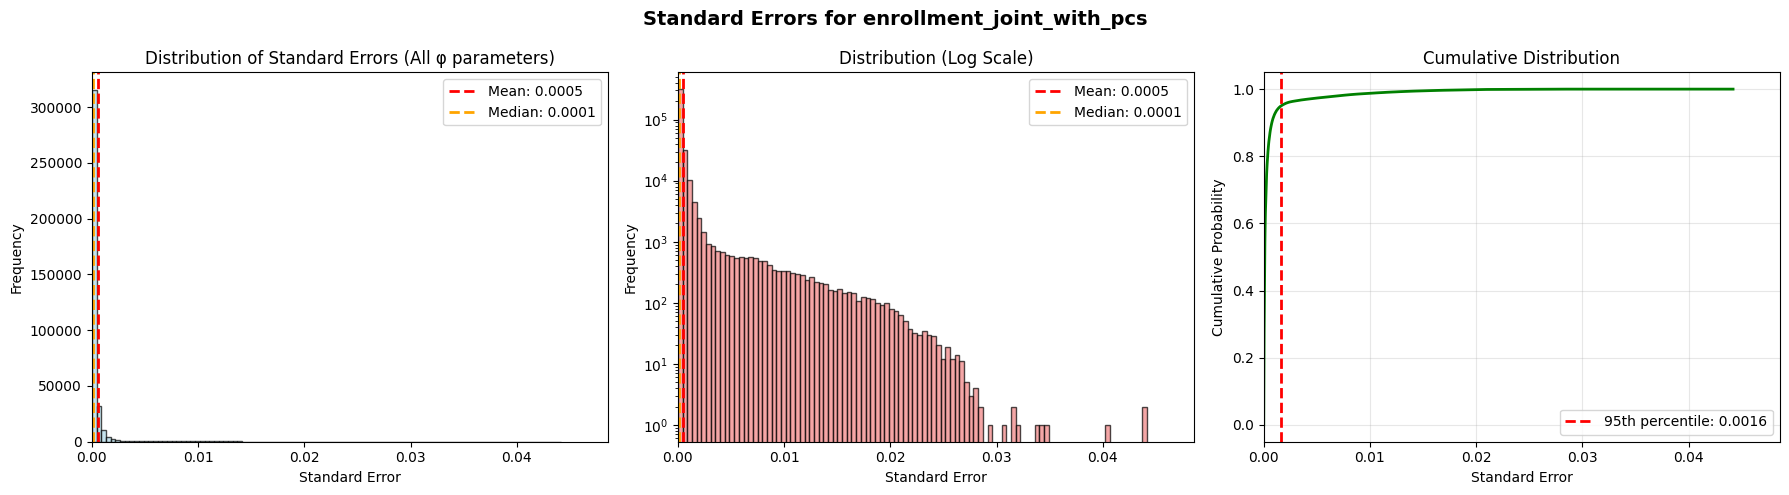


SUMMARY STATISTICS FOR ALL CONFIGURATIONS

full_retrospective_with_pcs (n_batches=40):
  Mean SE: 0.0010
  Median SE: 0.0002
  Max SE: 0.0773
  Min SE: 0.0000
  95th percentile SE: 0.0037
  99th percentile SE: 0.0181

fixed_phi_with_pcs (n_batches=40):
  Mean SE: 0.0000
  Median SE: 0.0000
  Max SE: 0.0000
  Min SE: 0.0000
  95th percentile SE: 0.0000
  99th percentile SE: 0.0000

full_retrospective_no_pcs (n_batches=40):
  Mean SE: 0.0010
  Median SE: 0.0002
  Max SE: 0.0757
  Min SE: 0.0000
  95th percentile SE: 0.0037
  99th percentile SE: 0.0181

enrollment_joint_with_pcs (n_batches=40):
  Mean SE: 0.0005
  Median SE: 0.0001
  Max SE: 0.0442
  Min SE: 0.0000
  95th percentile SE: 0.0016
  99th percentile SE: 0.0113


In [6]:
# Create the standard error distribution plot for each configuration
for config_name, result in results.items():
    all_ses = result['all_ses']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Standard Errors for {config_name}', fontsize=14, fontweight='bold')
    
    # Left plot: Distribution (Linear Scale)
    axes[0].hist(all_ses, bins=100, color='lightblue', edgecolor='black', alpha=0.7)
    mean_se = all_ses.mean()
    median_se = np.median(all_ses)
    axes[0].axvline(mean_se, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_se:.4f}')
    axes[0].axvline(median_se, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_se:.4f}')
    axes[0].set_xlabel('Standard Error')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Standard Errors (All φ parameters)')
    axes[0].legend()
    axes[0].set_xlim(0, min(0.06, all_ses.max() * 1.1))
    
    # Middle plot: Distribution (Log Scale)
    axes[1].hist(all_ses, bins=100, color='lightcoral', edgecolor='black', alpha=0.7)
    axes[1].axvline(mean_se, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_se:.4f}')
    axes[1].axvline(median_se, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_se:.4f}')
    axes[1].set_xlabel('Standard Error')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution (Log Scale)')
    axes[1].set_yscale('log')
    axes[1].legend()
    axes[1].set_xlim(0, min(0.06, all_ses.max() * 1.1))
    
    # Right plot: Cumulative Distribution
    sorted_ses = np.sort(all_ses)
    cumulative = np.arange(1, len(sorted_ses) + 1) / len(sorted_ses)
    axes[2].plot(sorted_ses, cumulative, color='green', linewidth=2)
    p95 = np.percentile(all_ses, 95)
    axes[2].axvline(p95, color='red', linestyle='--', linewidth=2, label=f'95th percentile: {p95:.4f}')
    axes[2].set_xlabel('Standard Error')
    axes[2].set_ylabel('Cumulative Probability')
    axes[2].set_title('Cumulative Distribution')
    axes[2].legend()
    axes[2].set_xlim(0, min(0.06, all_ses.max() * 1.1))
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Print summary statistics for each configuration
print("\n" + "="*80)
print("SUMMARY STATISTICS FOR ALL CONFIGURATIONS")
print("="*80)
for config_name, result in results.items():
    all_ses = result['all_ses']
    n_batches = result['n_batches']
    print(f"\n{config_name} (n_batches={n_batches}):")
    print(f"  Mean SE: {all_ses.mean():.4f}")
    print(f"  Median SE: {np.median(all_ses):.4f}")
    print(f"  Max SE: {all_ses.max():.4f}")
    print(f"  Min SE: {all_ses.min():.4f}")
    print(f"  95th percentile SE: {np.percentile(all_ses, 95):.4f}")
    print(f"  99th percentile SE: {np.percentile(all_ses, 99):.4f}")


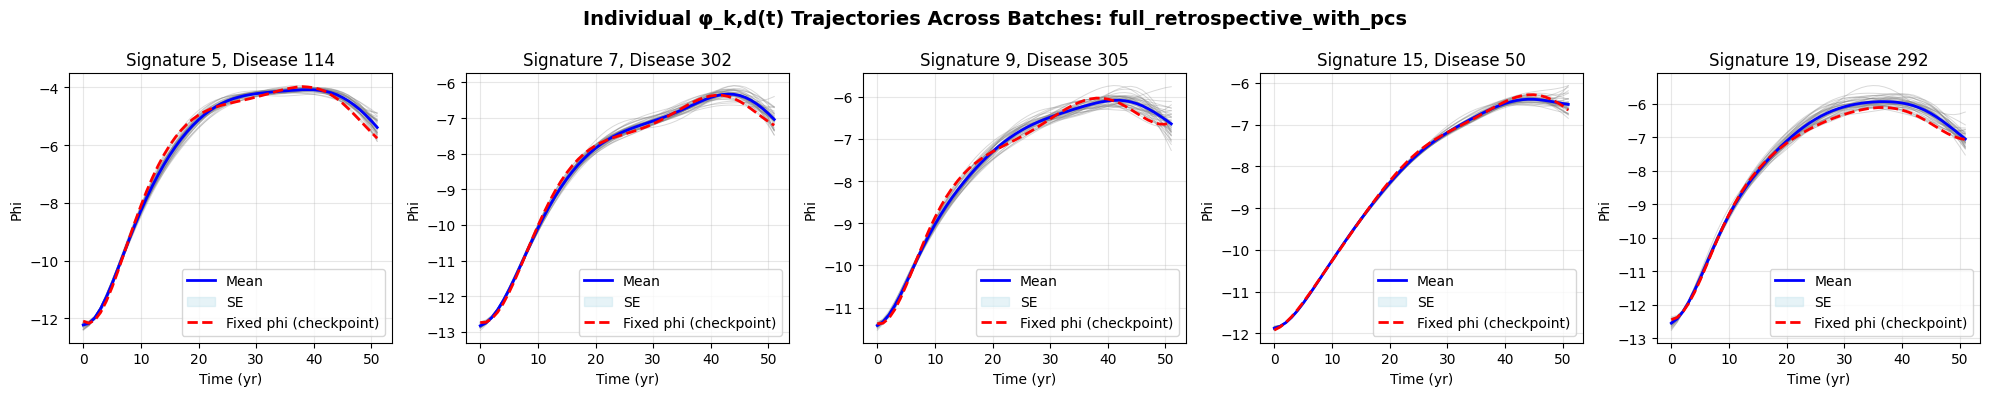


full_retrospective_with_pcs - Plotted signature-disease pairs:
  Signature 5, Disease 114
  Signature 7, Disease 302
  Signature 9, Disease 305
  Signature 15, Disease 50
  Signature 19, Disease 292


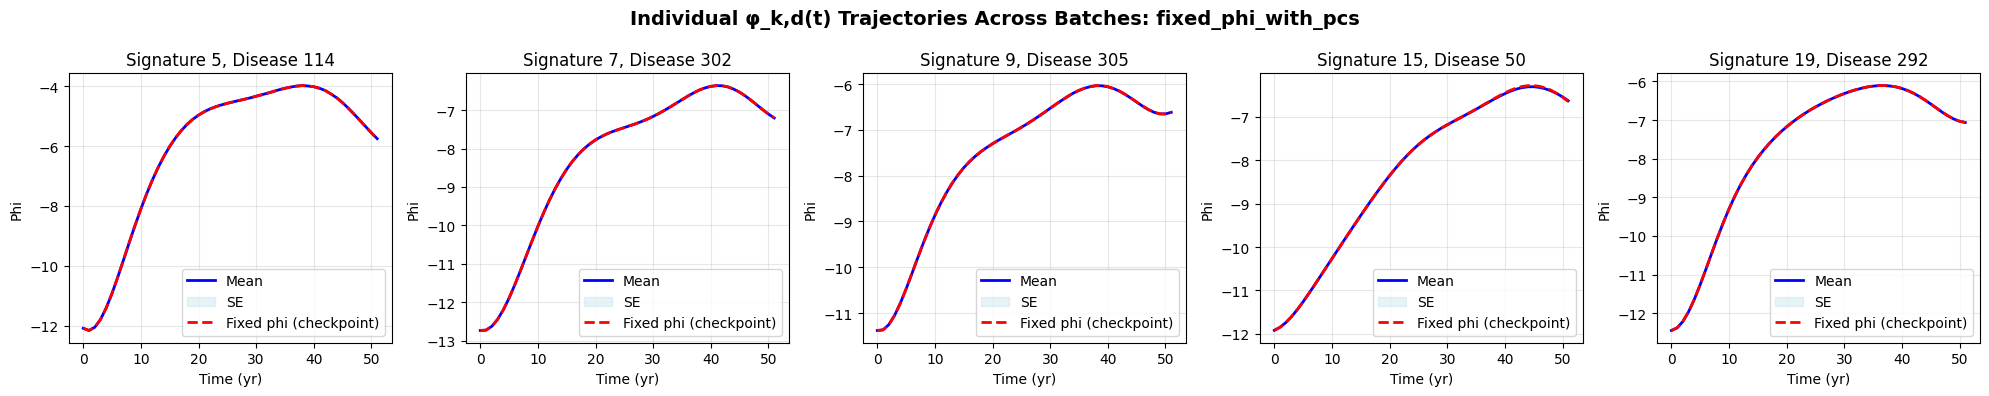


fixed_phi_with_pcs - Plotted signature-disease pairs:
  Signature 5, Disease 114
  Signature 7, Disease 302
  Signature 9, Disease 305
  Signature 15, Disease 50
  Signature 19, Disease 292


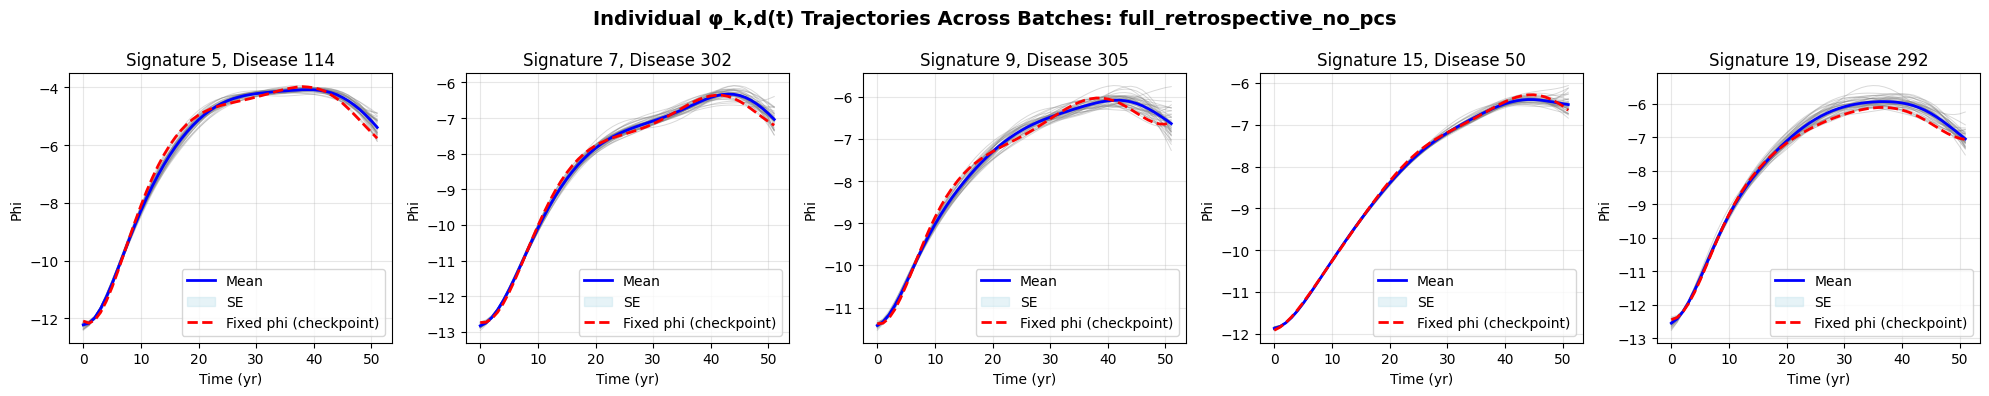


full_retrospective_no_pcs - Plotted signature-disease pairs:
  Signature 5, Disease 114
  Signature 7, Disease 302
  Signature 9, Disease 305
  Signature 15, Disease 50
  Signature 19, Disease 292


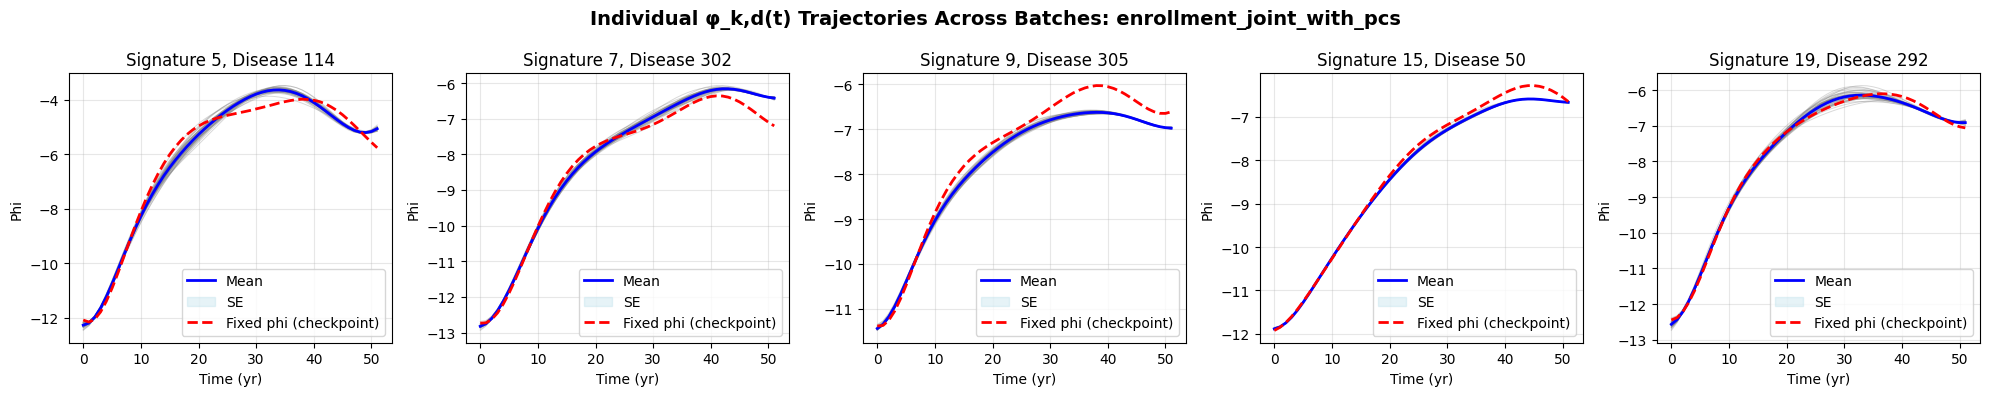


enrollment_joint_with_pcs - Plotted signature-disease pairs:
  Signature 5, Disease 114
  Signature 7, Disease 302
  Signature 9, Disease 305
  Signature 15, Disease 50
  Signature 19, Disease 292


In [7]:
# Plot individual phi trajectories across batches (like Panel A in Figure S5)
# Using specific signature-disease pairs:
# Signature 5, Disease 114
# Signature 7, Disease 302
# Signature 9, Disease 305
# Signature 15, Disease 50
# Signature 19, Disease 292

signature_disease_pairs = [
    (5, 114),
    (7, 302),
    (9, 305),
    (15, 50),
    (19, 292)
]

for config_name, result in results.items():
    phi_stack = result['phi_stack']  # shape: (n_batches, K, D, T)
    n_batches, K, D, T = phi_stack.shape
    
    # Create figure with subplots for each signature-disease pair
    fig, axes = plt.subplots(1, len(signature_disease_pairs), figsize=(20, 4))
    fig.suptitle(f'Individual φ_k,d(t) Trajectories Across Batches: {config_name}', 
                 fontsize=14, fontweight='bold')
    
    time_points = np.arange(T)  # Assuming time points are 0, 1, 2, ..., T-1
    
    for idx, (k, d) in enumerate(signature_disease_pairs):
        if k >= K:
            print(f"Warning: Signature {k} not available (max K={K-1})")
            continue
        if d >= D:
            print(f"Warning: Disease {d} not available (max D={D-1})")
            continue
            
        # Get phi trajectories for this (k, d) across all batches
        phi_trajectories = phi_stack[:, k, d, :]  # shape: (n_batches, T)
        
        # Calculate mean and SE across batches
        mean_phi = phi_trajectories.mean(axis=0)  # shape: (T,)
        se_phi = phi_trajectories.std(axis=0) / np.sqrt(n_batches)  # shape: (T,)
        
        # Plot individual batch trajectories (gray lines)
        for b in range(n_batches):
            axes[idx].plot(time_points, phi_trajectories[b], 
                          color='gray', alpha=0.3, linewidth=0.7)
        
        # Plot mean trajectory (blue line)
        axes[idx].plot(time_points, mean_phi, color='blue', 
                      linewidth=2, label='Mean')
        
        # Plot SE region (light blue shaded)
        axes[idx].fill_between(time_points, 
                              mean_phi - se_phi, 
                              mean_phi + se_phi, 
                              color='lightblue', alpha=0.3, label='SE')
        
        # Plot fixed phi from checkpoint (red line)
        if phi_fixed is not None:
            phi_fixed_K, phi_fixed_D, phi_fixed_T = phi_fixed.shape
            if k < phi_fixed_K and d < phi_fixed_D:
                # Handle time dimension mismatch if needed
                if phi_fixed_T == T:
                    phi_fixed_traj = phi_fixed[k, d, :]
                elif phi_fixed_T > T:
                    phi_fixed_traj = phi_fixed[k, d, :T]
                else:
                    # If fixed phi has fewer time points, pad or interpolate
                    phi_fixed_traj = np.interp(time_points, 
                                             np.linspace(0, T-1, phi_fixed_T), 
                                             phi_fixed[k, d, :])
                axes[idx].plot(time_points, phi_fixed_traj, color='red', 
                              linewidth=2, linestyle='--', label='Fixed phi (checkpoint)')
        
        axes[idx].set_xlabel('Time (yr)')
        axes[idx].set_ylabel('Phi')
        axes[idx].set_title(f'Signature {k}, Disease {d}')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print confirmation
    print(f"\n{config_name} - Plotted signature-disease pairs:")
    for k, d in signature_disease_pairs:
        if k < K and d < D:
            print(f"  Signature {k}, Disease {d}")


In [8]:
from create_master_checkpoints import *

In [9]:
# Import functions from create_master_checkpoints
import sys
sys.path.append('/Users/sarahurbut/aladynoulli2/claudefile/')
from create_master_checkpoints import pool_phi_from_batches, create_master_checkpoint

# Load initial_psi
data_dir = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/'
initial_psi = torch.load(data_dir + 'initial_psi_400k.pt', weights_only=False)
if torch.is_tensor(initial_psi):
    initial_psi = initial_psi.cpu().numpy()
print(f"Loaded initial_psi, shape: {initial_psi.shape}")

# Create pooled phi for retrospective data and compare with notebook results
print("\n" + "="*80)
print("Creating pooled phi for retrospective data")
print("="*80)
retrospective_pattern = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_*_*.pt'
phi_retrospective_pooled = pool_phi_from_batches(retrospective_pattern)

# Compare with notebook results (mean of phi_stack)
if 'full_retrospective_with_pcs' in results:
    phi_notebook_mean = results['full_retrospective_with_pcs']['phi_stack'].mean(axis=0)
    print(f"\nComparing pooled phi with notebook mean:")
    print(f"  Notebook mean shape: {phi_notebook_mean.shape}")
    print(f"  Pooled phi shape: {phi_retrospective_pooled.shape}")
    print(f"  Are they equal? {np.allclose(phi_retrospective_pooled, phi_notebook_mean)}")
    print(f"  Max difference: {np.abs(phi_retrospective_pooled - phi_notebook_mean).max():.10f}")
    print(f"  Mean difference: {np.abs(phi_retrospective_pooled - phi_notebook_mean).mean():.10f}")

# Create pooled phi for enrollment data and compare
print("\n" + "="*80)
print("Creating pooled phi for enrollment data")
print("="*80)
enrollment_pattern = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_prediction_jointphi_sex_pcs/enrollment_model_W0.0001_batch_*_*.pt'
phi_enrollment_pooled = pool_phi_from_batches(enrollment_pattern)

# Compare with notebook results
if 'enrollment_joint_with_pcs' in results:
    phi_enroll_notebook_mean = results['enrollment_joint_with_pcs']['phi_stack'].mean(axis=0)
    print(f"\nComparing pooled phi with notebook mean:")
    print(f"  Notebook mean shape: {phi_enroll_notebook_mean.shape}")
    print(f"  Pooled phi shape: {phi_enrollment_pooled.shape}")
    print(f"  Are they equal? {np.allclose(phi_enrollment_pooled, phi_enroll_notebook_mean)}")
    print(f"  Max difference: {np.abs(phi_enrollment_pooled - phi_enroll_notebook_mean).max():.10f}")
    print(f"  Mean difference: {np.abs(phi_enrollment_pooled - phi_enroll_notebook_mean).mean():.10f}")

# Create master checkpoint files
print("\n" + "="*80)
print("Creating master checkpoint files")
print("="*80)
output_dir = data_dir

# Master checkpoint for retrospective (all data)
output_path_retro = output_dir + 'master_for_fitting_pooled_all_data.pt'
create_master_checkpoint(
    phi_retrospective_pooled,
    initial_psi,
    output_path_retro,
    description="Pooled phi from all retrospective batches + initial_psi"
)

# Master checkpoint for enrollment data
output_path_enroll = output_dir + 'master_for_fitting_pooled_enrollment_data.pt'
create_master_checkpoint(
    phi_enrollment_pooled,
    initial_psi,
    output_path_enroll,
    description="Pooled phi from all enrollment batches + initial_psi"
)

# Verify the checkpoints were created correctly
print("\n" + "="*80)
print("Verifying master checkpoints")
print("="*80)
for checkpoint_path, expected_phi in [
    (output_path_retro, phi_retrospective_pooled),
    (output_path_enroll, phi_enrollment_pooled)
]:
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    loaded_phi = checkpoint['model_state_dict']['phi']
    if torch.is_tensor(loaded_phi):
        loaded_phi = loaded_phi.cpu().numpy()
    
    print(f"\n{checkpoint_path}:")
    print(f"  Description: {checkpoint.get('description', 'N/A')}")
    print(f"  Phi matches? {np.allclose(loaded_phi, expected_phi)}")
    print(f"  Max difference: {np.abs(loaded_phi - expected_phi).max():.10f}")
    print(f"  Psi shape: {checkpoint['model_state_dict']['psi'].shape}")

print("\n✓ Master checkpoints created and verified!")


Loaded initial_psi, shape: (20, 348)

Creating pooled phi for retrospective data
Found 40 files matching pattern: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_*_*.pt
Loaded phi from enrollment_model_W0.0001_batch_0_10000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_100000_110000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_10000_20000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_110000_120000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_120000_130000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_130000_140000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_140000_150000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_150000_160000.pt, shape: (21, 348, 52)
Loaded phi from enrollment_model_W0.0001_batch_160000_170000.pt, shape: (21, 348, 52)
Loade

cd /Users/sarahurbut/aladynoulli2/claudefile

# Fixed phi from pooled enrollment data (10 batches)
nohup python run_aladyn_predict_with_master.py \
    --trained_model_path /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/master_for_fitting_pooled_enrollment_data.pt \
    --output_dir /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_ENROLLMENT_pooled/ \
    --max_batches 10 \
    > predict_enrollment_pooled.log 2>&1 &

# Fixed phi from pooled retrospective (all data) (10 batches)
nohup python run_aladyn_predict_with_master.py \
    --trained_model_path /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/master_for_fitting_pooled_all_data.pt \
    --output_dir /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_RETROSPECTIVE_pooled/ \
    --max_batches 10 \
    > predict_retrospective_pooled.log 2>&1 &

In [ ]:
cd /Users/sarahurbut/aladynoulli2/claudefile

nohup python run_aladyn_predict_with_master.py \
    --trained_model_path /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/master_for_fitting_pooled_enrollment_data.pt \
    --output_dir /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_ENROLLMENT_pooled/ \
    --start_batch 10 \
    --max_batches 30 \
    > predict_enrollment_pooled_batches_10_40.log 2>&1 &

In [ ]:
nohup python run_aladyn_predict_with_master.py \
    --trained_model_path /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/master_for_fitting_pooled_all_data.pt \
    --output_dir /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_RETROSPECTIVE_pooled/ \
    --start_batch 10 \
    --max_batches 30 \
    > predict_retrospective_pooled_batches_10_40.log 2>&1 &